# 1. Import modules and load MERFISH data 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import anndata
import scanpy as sc
import os

import matplotlib.pyplot as plt

In [2]:
baysor_output_folder = r'lab/weissman_imaging/wcolgan/MERFISH_Data/20240404-Untreated_Spine_MF5/Baysor'
# generate post-analysis folders
#postanalysis_folder = merlin_output_folder+'_PostAnalysis'
postanalysis_folder = '/lab/weissman_imaging/puzheng/MERFISH_analysis/20240404-untreatedCord_MF5/PostAnalysis'
if not os.path.exists(postanalysis_folder):
    print(f"Create postanalysis_folder: {postanalysis_folder}")
    os.makedirs(postanalysis_folder)
else:
    print(f"Use postanalysis_folder: {postanalysis_folder}")

Use postanalysis_folder: /lab/weissman_imaging/puzheng/MERFISH_analysis/20240404-untreatedCord_MF5/PostAnalysis


In [3]:
os.listdir(baysor_output_folder)

['baysor_params.dump.toml',
 'baysor_log.log',
 'baysor',
 'baysor_cell_stats.csv',
 'baysor_counts.tsv',
 'baysor_polygons.json',
 'baysor_diagnostics.html',
 'baysor_borders.html']

# 2. Load MERLin analysis results

In [4]:
# Load Cell information
cell_meta_data_file = os.path.join(baysor_output_folder, 'baysor_cell_stats.csv')
cell_meta_data = pd.read_csv(cell_meta_data_file)
cell_meta_data

,cell,x,y,z,cluster,n_transcripts,density,elongation,area,avg_confidence,avg_assignment_confidence,max_cluster_frac,lifespan
0,CRd1f205fec-1,-3633.899873,585.342105,2.818182,4,11,2.831,12.450,3.885,0.9576,0.9000,0.636364,10
1,CRd1f205fec-2,-3627.738867,594.244082,1.166667,4,6,2.098,2.309,2.860,0.9955,0.8667,1.000000,10
2,CRd1f205fec-3,-3633.936472,600.214828,6.777778,4,117,1.975,3.461,59.230,0.9979,0.8667,0.803419,10
3,CRd1f205fec-4,-3649.618718,612.026957,6.857143,1,28,1.207,2.904,23.200,0.9596,0.8036,0.750000,10
4,CRd1f205fec-5,-3639.293683,605.546630,5.257340,5,579,2.818,2.564,205.500,0.9982,0.9610,0.801382,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85960,CRd1f205fec-85961,4876.328000,1027.599900,1.000000,1,1,NaN,NaN,NaN,0.9951,0.1000,1.000000,1
85961,CRd1f205fec-85962,6164.430000,1389.857300,5.000000,6,1,NaN,NaN,NaN,0.9984,0.1000,1.000000,1
85962,CRd1f205fec-85963,-2967.178250,1330.419250,5.500000,5,2,NaN,NaN,NaN,0.9978,0.1000,1.000000,1
85963,CRd1f205fec-85964,-1942.573200,881.514040,3.000000,1,1,NaN,NaN,NaN,0.9987,0.1000,1.000000,1


In [5]:
# Load decoded counts information
counts_file_mer = os.path.join(baysor_output_folder, 'baysor_counts.tsv')
gene_counts = []
with open(counts_file_mer, 'r') as _f:
    gene_names = _f.readline().strip().split('\t')
    for _line in _f.readlines():
        gene_counts.append(np.array(_line.split('\t'), dtype=np.int32))
gene_counts = np.array(gene_counts)

cell_count_df = pd.DataFrame(columns=gene_names, data=gene_counts.transpose())
cell_count_df['cell'] = cell_meta_data['cell']
cell_count_df.set_index('cell', inplace=True)

In [6]:
adata = anndata.AnnData(cell_count_df)
adata.obs = adata.obs.merge(cell_meta_data, left_index=True, right_on='cell').set_index('cell',)

# 3. Filter the MERFISH data 

In [7]:
# Calculate quality control metrics
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

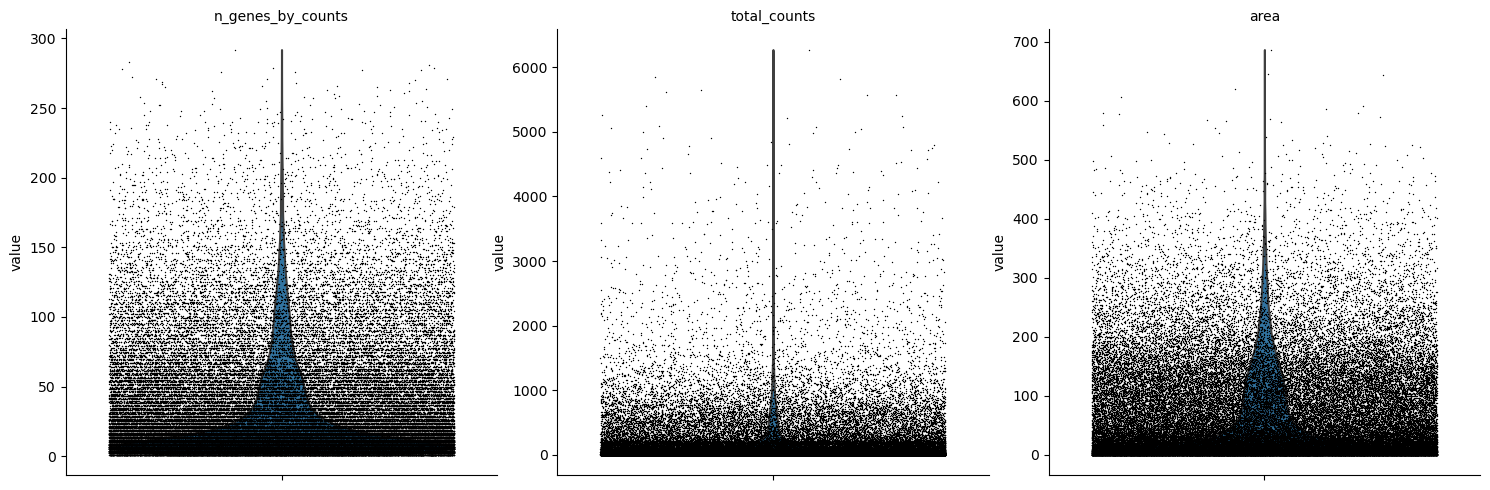

In [8]:
# A violin plot of some of the computed quality measures:
# - the number of genes expressed in the count matrix
# - the total counts per cell
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'area'],
             jitter=0.4, multi_panel=True)

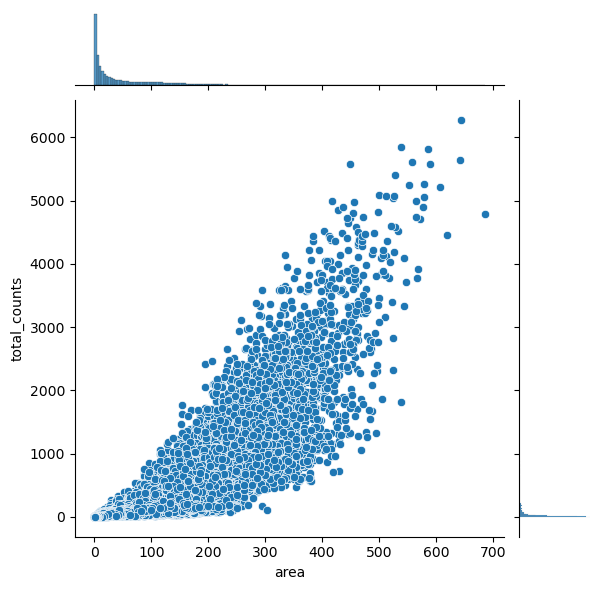

In [9]:
sns.jointplot(data=adata.obs, x='area', y='total_counts')

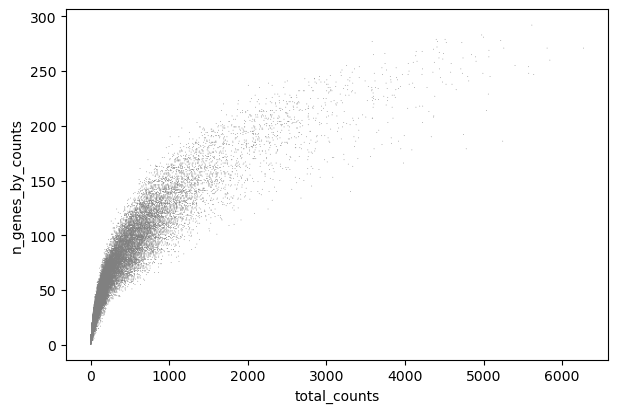

In [10]:
# Plot the distributions of gene counts
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [11]:
gene_count_threshold = 5
total_count_threshold = 10
volume_threshold = 150
elongation_upper_threshold = 6
# Filtering
adata = adata[adata.obs['n_genes_by_counts'] > gene_count_threshold]
adata = adata[adata.obs['total_counts'] > total_count_threshold]
adata = adata[adata.obs['area'] > volume_threshold]
adata = adata[adata.obs['elongation'] <= elongation_upper_threshold]

print(len(adata) / len(cell_meta_data) , len(adata))

0.12014191822253242 10328


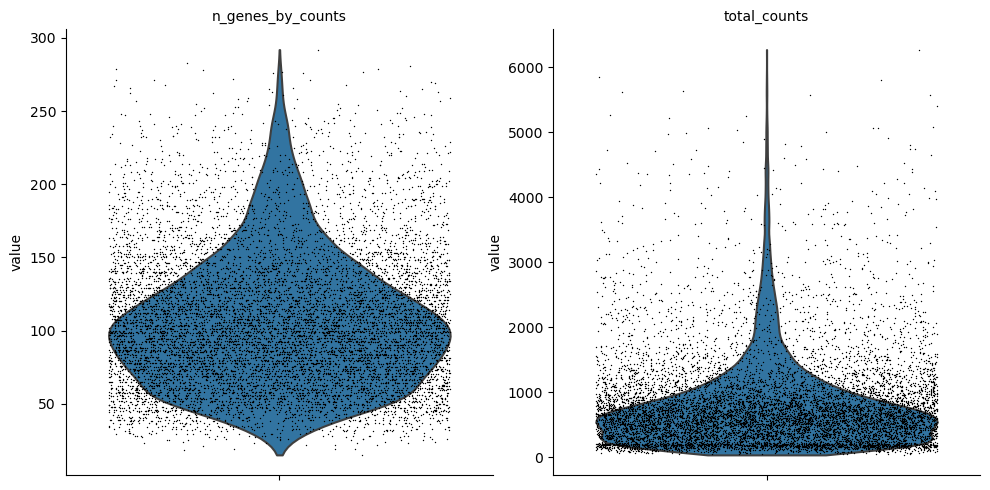

In [12]:
# A violin plot of some of the computed quality measures:
# - the number of genes expressed in the count matrix
# - the total counts per cell
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

In [13]:
np.mean(adata.obs['total_counts'])

798.3465336948102

In [14]:
adata_raw = adata.copy()

# 4. PCA and UMAP of the MERFISH data

/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


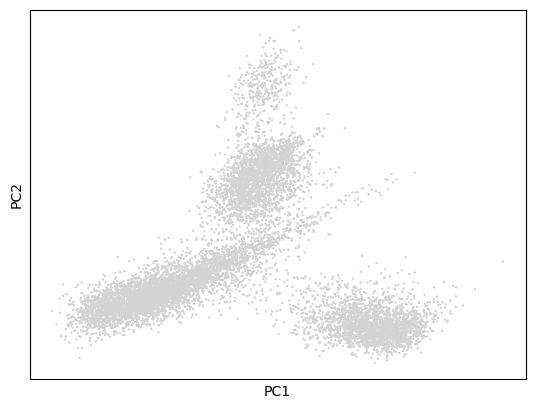

CPU times: user 1min 9s, sys: 4.32 s, total: 1min 13s
Wall time: 3.24 s


In [17]:
%%time
# copy adata from adata_raw:
adata = adata_raw.copy()
# Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell
sc.pp.normalize_total(adata, target_sum=1e2)
# Logarithmize the data
sc.pp.log1p(adata)
# Regress out total counts
sc.pp.regress_out(adata, 'total_counts')
# Convert gene expressions to Z-scores
sc.pp.scale(adata, max_value=10)
# Principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
# Plot the PCA results
sc.pl.pca(adata)

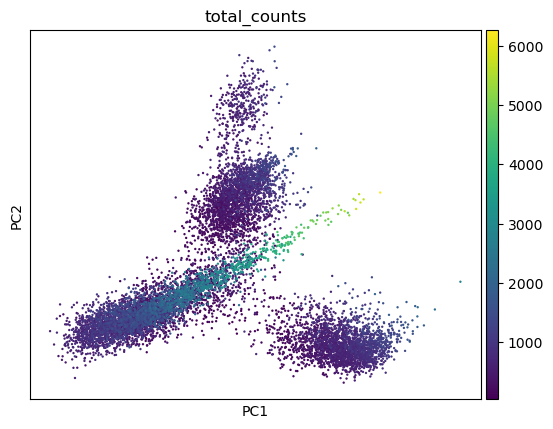

In [29]:
sc.pl.pca(adata, color='total_counts')

In [18]:
%%time
# Computing the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=8, n_pcs=30)

CPU times: user 28.9 s, sys: 2.87 s, total: 31.8 s
Wall time: 25.7 s


In [19]:
%%time
# Clustering
sc.tl.leiden(adata, resolution=1)

CPU times: user 589 ms, sys: 15.6 ms, total: 605 ms
Wall time: 600 ms


/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


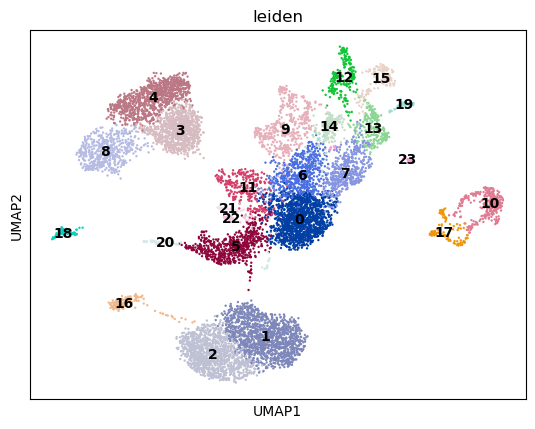

CPU times: user 17.3 s, sys: 677 ms, total: 18 s
Wall time: 6.19 s


In [20]:
%%time
# Embed with UMAP
sc.tl.umap(adata)
# Plot the UMAP
sc.pl.umap(adata, color='leiden', legend_loc='on data')

/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


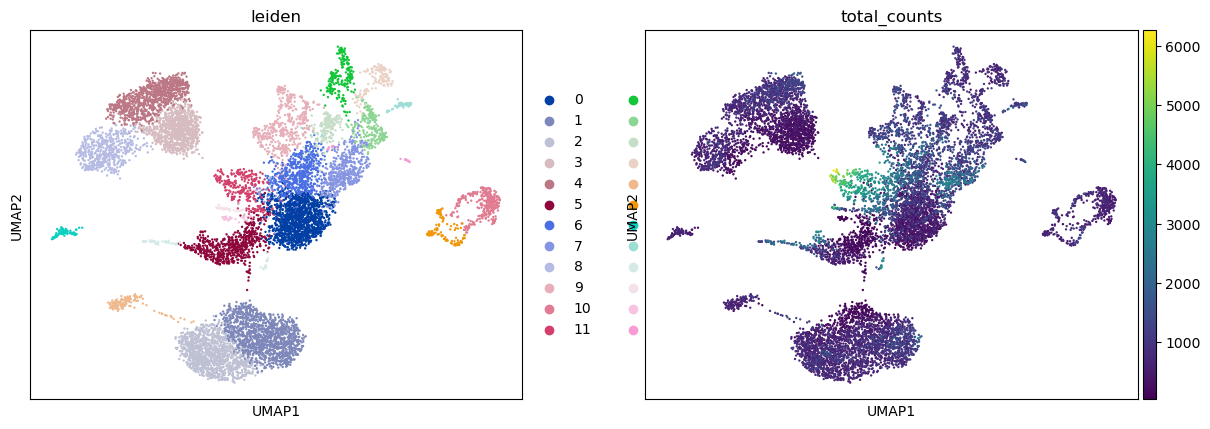

In [21]:
sc.pl.umap(adata, color=['leiden', 'total_counts'],)

## 4.1 Visualize clusters in space

<Figure size 640x480 with 0 Axes>

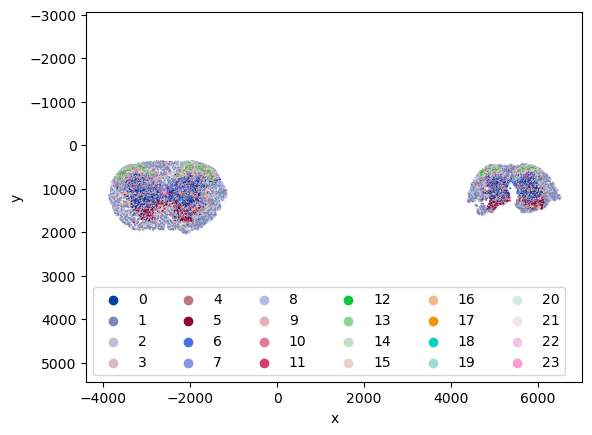

In [23]:
# visualzie the spatial dist for clusters
#sel_clusters = ['0', '1', '2', '3', '4', '5']
sel_clusters = np.unique(adata.obs['leiden'])
plt.figure()
sel_inds = [_i for _i, _cls in zip(adata.obs.index, adata.obs['leiden']) if _cls in sel_clusters]
plt.figure()
ax1 = sns.scatterplot(data=adata.obs, x='x', y='y', 
                      color=[0.8,0.8,0.8], s=2., legend=True, linewidth=0)

ax = sns.scatterplot(data=adata.obs.loc[sel_inds], x='x', y='y', 
                     palette = {str(_i):_c for _i, _c in enumerate((adata.uns['leiden_colors']))},
                     #palette='Spectral',#'tab20',
                     hue='leiden', s=2., legend=True, linewidth=0)
ax.grid(False)
plt.axis('equal')
hs, ls = ax.get_legend_handles_labels()
ax.legend(hs,ls, ncol=6, loc=3)
#plt.xlim([-6500,-2000])
#plt.ylim([-2000,2500])
ax.invert_yaxis()
#plt.savefig(os.path.join(figure_folder, 'spatial-all_clusters.png'), transparent=True)
plt.show()

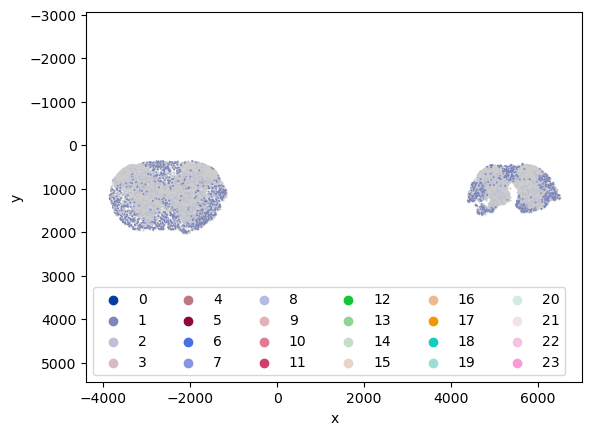

In [25]:
#%matplotlib widget
# visualzie the spatial dist for clusters
sel_clusters = ['1', '2',]
plt.figure()
sel_inds = [_i for _i, _cls in zip(adata.obs.index, adata.obs['leiden']) if _cls in sel_clusters]
ax1 = sns.scatterplot(data=adata.obs, x='x', y='y', 
                      color=[0.8,0.8,0.8], s=2., legend=True, linewidth=0)

ax = sns.scatterplot(data=adata.obs.loc[sel_inds], x='x', y='y', 
                     palette = {str(_i):_c for _i, _c in enumerate((adata.uns['leiden_colors']))},
                     #palette='Spectral',#'tab20',
                     hue='leiden', s=2., legend=True, linewidth=0)
ax.grid(False)
plt.axis('equal')
hs, ls = ax.get_legend_handles_labels()
ax.legend(hs,ls, ncol=6, loc=3)
#plt.xlim([-6500,-2000])
#plt.ylim([-2000,2500])
ax.invert_yaxis()
#plt.savefig(os.path.join(figure_folder, 'spatial-all_clusters.png'), transparent=True)
plt.show()

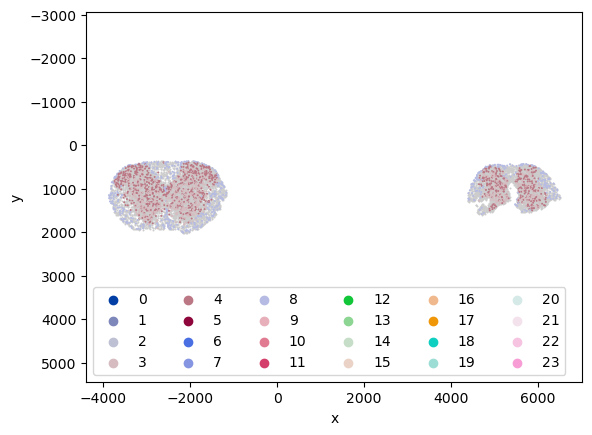

In [26]:
#%matplotlib widget
# visualzie the spatial dist for clusters
sel_clusters = ['3', '4', '8']
plt.figure()
sel_inds = [_i for _i, _cls in zip(adata.obs.index, adata.obs['leiden']) if _cls in sel_clusters]
ax1 = sns.scatterplot(data=adata.obs, x='x', y='y', 
                      color=[0.8,0.8,0.8], s=2., legend=True, linewidth=0)

ax = sns.scatterplot(data=adata.obs.loc[sel_inds], x='x', y='y', 
                     palette = {str(_i):_c for _i, _c in enumerate((adata.uns['leiden_colors']))},
                     #palette='Spectral',#'tab20',
                     hue='leiden', s=2., legend=True, linewidth=0)
ax.grid(False)
plt.axis('equal')
hs, ls = ax.get_legend_handles_labels()
ax.legend(hs,ls, ncol=6, loc=3)
#plt.xlim([-6500,-2000])
#plt.ylim([-2000,2500])
ax.invert_yaxis()
#plt.savefig(os.path.join(figure_folder, 'spatial-all_clusters.png'), transparent=True)
plt.show()

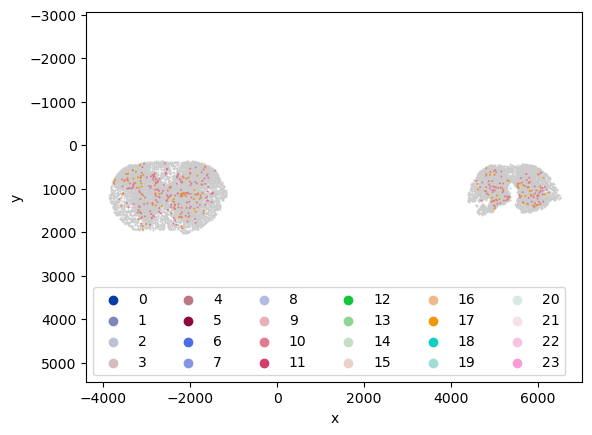

In [27]:
#%matplotlib widget
# visualzie the spatial dist for clusters
sel_clusters = ['10', '17', ]
plt.figure()
sel_inds = [_i for _i, _cls in zip(adata.obs.index, adata.obs['leiden']) if _cls in sel_clusters]
ax1 = sns.scatterplot(data=adata.obs, x='x', y='y', 
                      color=[0.8,0.8,0.8], s=2., legend=True, linewidth=0)

ax = sns.scatterplot(data=adata.obs.loc[sel_inds], x='x', y='y', 
                     palette = {str(_i):_c for _i, _c in enumerate((adata.uns['leiden_colors']))},
                     #palette='Spectral',#'tab20',
                     hue='leiden', s=2., legend=True, linewidth=0)
ax.grid(False)
plt.axis('equal')
hs, ls = ax.get_legend_handles_labels()
ax.legend(hs,ls, ncol=6, loc=3)
#plt.xlim([-6500,-2000])
#plt.ylim([-2000,2500])
ax.invert_yaxis()
#plt.savefig(os.path.join(figure_folder, 'spatial-all_clusters.png'), transparent=True)
plt.show()

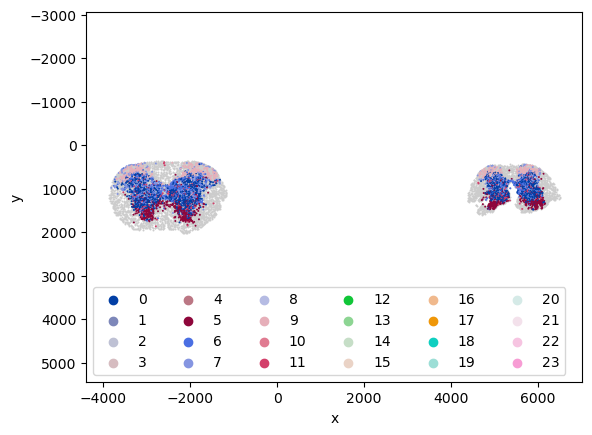

In [28]:
#%matplotlib widget
# visualzie the spatial dist for clusters
sel_clusters = ['0', '5', '6', '7', '9', '11']
plt.figure()
sel_inds = [_i for _i, _cls in zip(adata.obs.index, adata.obs['leiden']) if _cls in sel_clusters]
ax1 = sns.scatterplot(data=adata.obs, x='x', y='y', 
                      color=[0.8,0.8,0.8], s=2., legend=True, linewidth=0)

ax = sns.scatterplot(data=adata.obs.loc[sel_inds], x='x', y='y', 
                     palette = {str(_i):_c for _i, _c in enumerate((adata.uns['leiden_colors']))},
                     #palette='Spectral',#'tab20',
                     hue='leiden', s=2., legend=True, linewidth=0)
ax.grid(False)
plt.axis('equal')
hs, ls = ax.get_legend_handles_labels()
ax.legend(hs,ls, ncol=6, loc=3)
#plt.xlim([-6500,-2000])
#plt.ylim([-2000,2500])
ax.invert_yaxis()
#plt.savefig(os.path.join(figure_folder, 'spatial-all_clusters.png'), transparent=True)
plt.show()

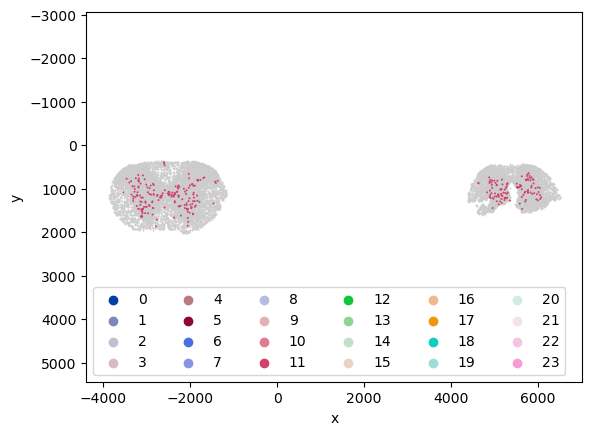

In [30]:
#%matplotlib widget
# visualzie the spatial dist for clusters
sel_clusters = ['11']
plt.figure()
sel_inds = [_i for _i, _cls in zip(adata.obs.index, adata.obs['leiden']) if _cls in sel_clusters]
ax1 = sns.scatterplot(data=adata.obs, x='x', y='y', 
                      color=[0.8,0.8,0.8], s=2., legend=True, linewidth=0)

ax = sns.scatterplot(data=adata.obs.loc[sel_inds], x='x', y='y', 
                     palette = {str(_i):_c for _i, _c in enumerate((adata.uns['leiden_colors']))},
                     #palette='Spectral',#'tab20',
                     hue='leiden', s=2., legend=True, linewidth=0)
ax.grid(False)
plt.axis('equal')
hs, ls = ax.get_legend_handles_labels()
ax.legend(hs,ls, ncol=6, loc=3)
#plt.xlim([-6500,-2000])
#plt.ylim([-2000,2500])
ax.invert_yaxis()
#plt.savefig(os.path.join(figure_folder, 'spatial-all_clusters.png'), transparent=True)
plt.show()

# 5. Check count for each cell for genes of interest

/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


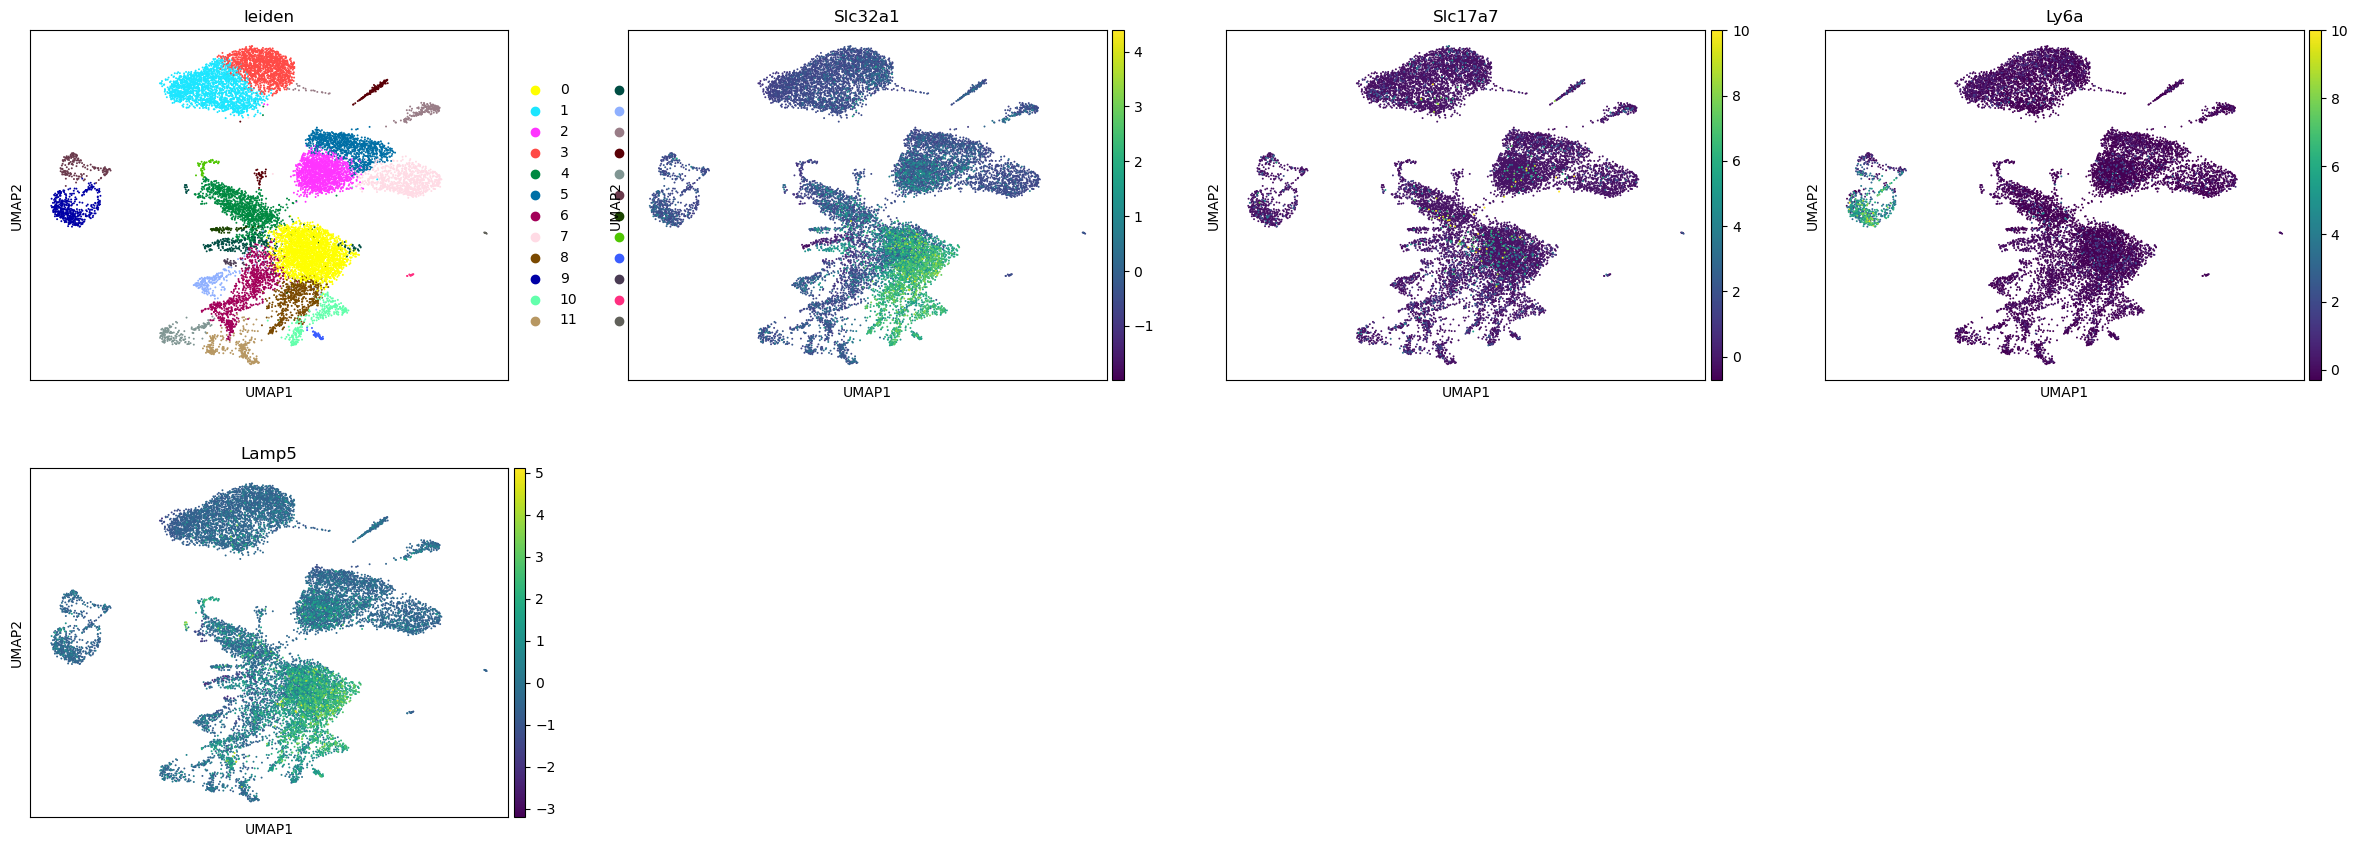

In [69]:
%matplotlib inline
# Visualize marker genes
marker_genes = ['Slc32a1', 'Slc17a7','Ly6a' ,'Lamp5']
marker_genes = ['leiden']+[g for g in marker_genes if (g in adata.var.index)]

sc.pl.umap(adata, color=marker_genes)

## Check total counts

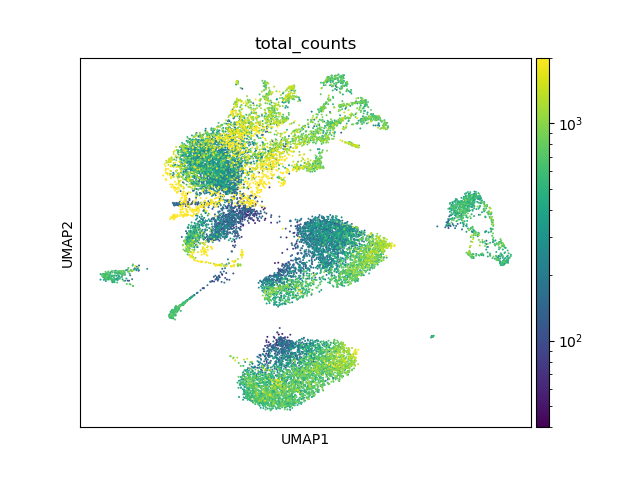

In [49]:
sc.pl.umap(adata, color='total_counts', norm=LogNorm(vmin=40, vmax=2000))

# 7. Save the analyzed MERFISH adata in h5ad for later use (e.g., cell classifer)

In [32]:
# save raw
raw_save_filename = os.path.join(postanalysis_folder, 'adata_raw.h5ad')
overwrite = True

if not os.path.exists(raw_save_filename) or overwrite:
    adata_raw.write(raw_save_filename)
    print(f"Save raw data to {raw_save_filename}")
else:  
    print(f"Skip saving raw data to {raw_save_filename}")

Save raw data to /lab/weissman_imaging/puzheng/MERFISH_analysis/20240404-untreatedCord_MF5/PostAnalysis/adata_raw.h5ad


In [31]:
save_filename = os.path.join(os.path.join(postanalysis_folder, 'filtered_cluster_data.h5ad'))

overwrite = True

if not os.path.exists(save_filename) or overwrite:
    print(f"save adata into file: {save_filename}")
    adata.write(save_filename)
else:
    print(f"savefile: {save_filename} already exists")

save adata into file: /lab/weissman_imaging/puzheng/MERFISH_analysis/20240404-untreatedCord_MF5/PostAnalysis/filtered_cluster_data.h5ad
